In [35]:
import numpy as np
import pandas as pd
import ctypes
import matplotlib.pyplot as plt

import time
import os
import scipy.integrate
import time

filename_so = "./bondarenko.so"
bondarenko = ctypes.CDLL(filename_so)
filename_so_abs = "./model.so"
model = ctypes.CDLL(filename_so_abs)

bondarenko.fun.argtypes = [
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]
model.initialize_states_default.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

def fun_creator(params):
    def fun(t,y):   
        ydot = np.zeros(186)
        bondarenko.fun(t, y, ydot, params)
        return ydot
    return fun

In [36]:
def solve(fun, y0, t_bound, params):
    CL = params[0]
    y0 = np.zeros(186)
    model.initialize_states_default(y0)
    total_stims = t_bound/CL
    fun = fun_creator(params)
    output = []
    time = []
    solver = scipy.integrate.LSODA(fun, 0.0, y0, CL)
    for i in range(1, int(total_stims)+1):
        while(solver.status == "running"):
            solver.step()
            out = solver.dense_output()
            time.append(solver.t)
            output.append(out(solver.t))
        t0 = i*CL
        y0 = np.array(output[-1])
        solver = scipy.integrate.LSODA(fun, t0, y0, t0+CL)
        #print(t0)
    return time, np.array(output)

In [37]:
y0 = np.zeros(186)
model.initialize_states_default(y0)

params = np.array(pd.read_csv("params", delimiter = '\t').values[:,1]).astype("float64")
fun = fun_creator(params)

t_bound = 1000.0 #ms

In [44]:
start_time = time.time()
timespace, output = solve(fun, y0, t_bound, params)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.4586315155029297 seconds ---


In [39]:
output

array([[ 0.00000000e+00, -8.05532639e+01,  9.27902693e-02, ...,
         1.18432437e-02,  5.09205226e-04,  9.98092768e-01],
       [ 0.00000000e+00, -8.02236354e+01,  9.27902699e-02, ...,
         1.18432437e-02,  5.09278937e-04,  9.98092766e-01],
       [ 0.00000000e+00, -7.95647794e+01,  9.27902717e-02, ...,
         1.18432437e-02,  5.09505192e-04,  9.98092759e-01],
       ...,
       [ 0.00000000e+00, -8.08703107e+01,  9.28891589e-02, ...,
         1.18432437e-02,  5.10018780e-04,  9.97339873e-01],
       [ 0.00000000e+00, -8.08703922e+01,  9.28877489e-02, ...,
         1.18432437e-02,  5.10013363e-04,  9.97346363e-01],
       [ 0.00000000e+00, -8.08704730e+01,  9.28863801e-02, ...,
         1.18432437e-02,  5.10007983e-04,  9.97352797e-01]])

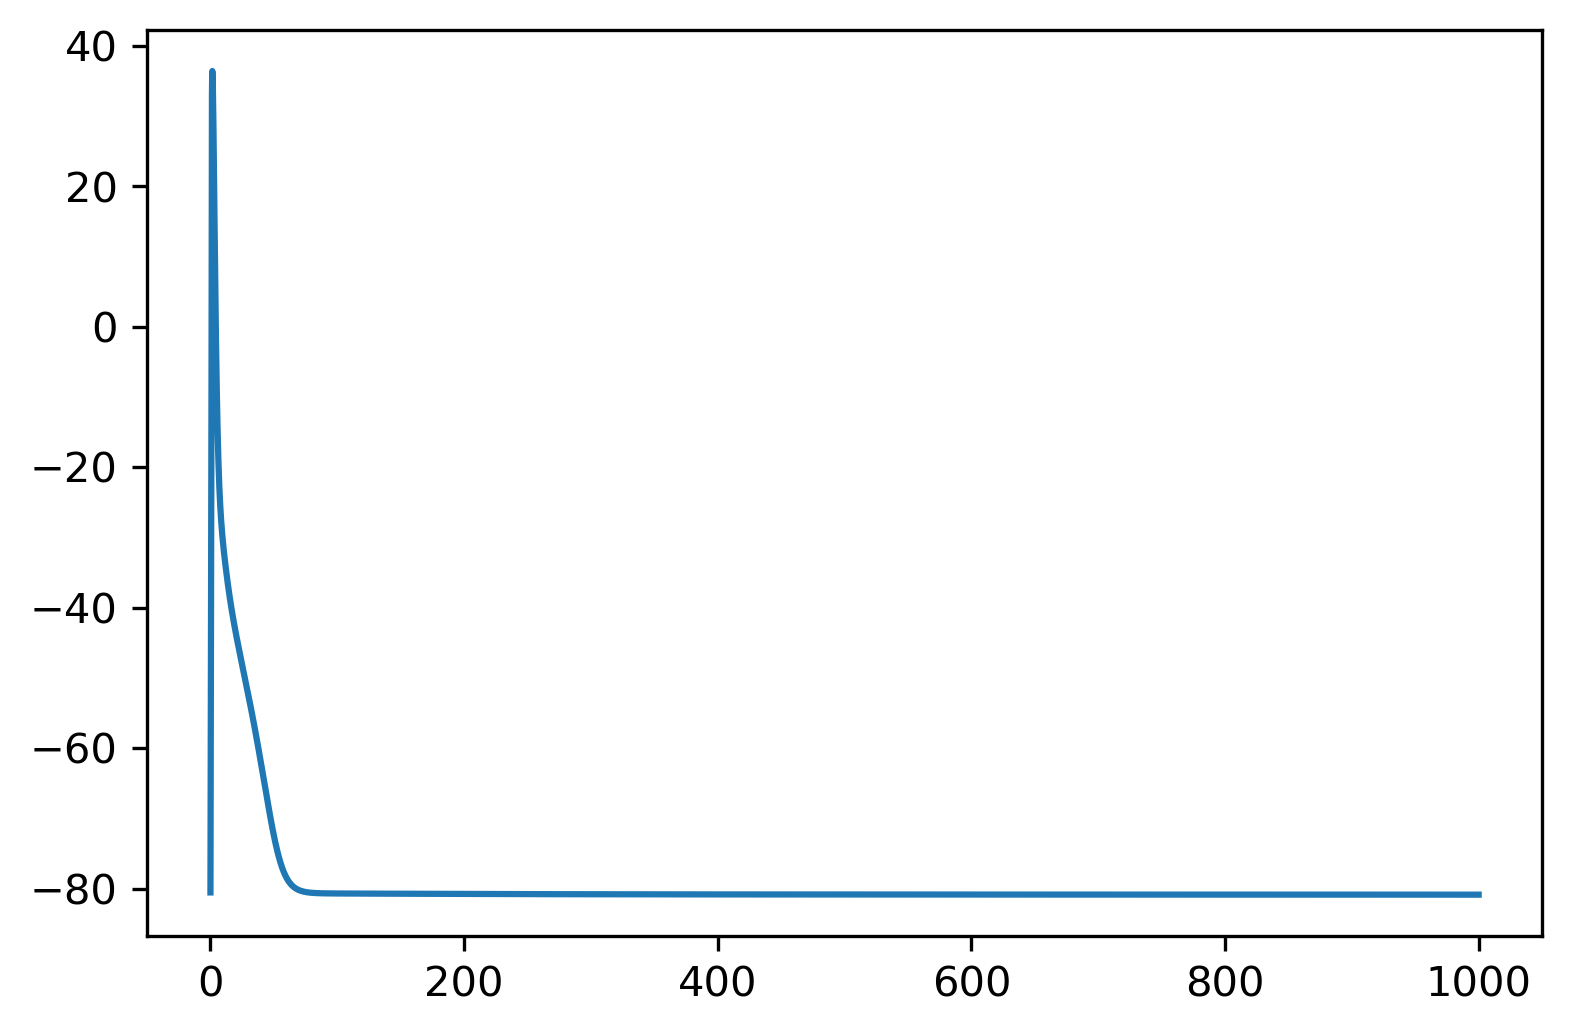

In [40]:
plt.figure(dpi=300)
plt.plot(timespace[:], output[:,1])

In [1]:
data = pd.read_csv("potential11.txt", sep = "\t", header = None).values

NameError: name 'pd' is not defined

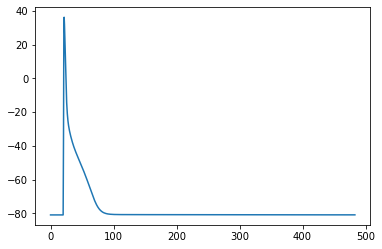

In [14]:
plt.plot(data[:500,0],data[:500,1])

In [15]:
time = data[:500,0]
AP = [data[:500,0], data[:500,1]]

RMP = np.min(AP[1][np.nonzero(time > 20)])

Vpeak = np.max(AP[1])

dVdt = np.divide(np.diff(AP[1]), np.diff(time))

dVdt_max = np.max(dVdt)

AP_delta = Vpeak - RMP

AP_normalized = (AP[1] - RMP)/AP_delta

APD90 = np.max(time[AP_normalized>0.1]) - np.min(time[AP_normalized>0.1])

APD50 = np.max(time[AP_normalized>0.5]) - np.min(time[AP_normalized>0.5])

APD40 = np.max(time[AP_normalized>0.6]) - np.min(time[AP_normalized>0.6])

Tri90_40 = APD90 - APD40

In [16]:
markers = [RMP, Vpeak, dVdt_max, APD90, APD50, APD40, Tri90_40]
markers

[-80.8452, 36.2106, 125.0086, 45.404700000000005, 5.5, 4.0, 41.404700000000005]

| Marker | Value |
| --- | --- |
| RMP | -80.8705 mV |
| Vpeak | 36.2418 mV |
| dVdt_max | 125 mV/ms |
| APD90 | 45 ms |
| APD50 | 5.5 ms |
| APD40 | 4.0 ms |
| Tri90_40 | 41 ms |

In [1]:
plt.figure(dpi = 300)
data = pd.read_csv("potential11.txt", sep = "\t", header = None).values

plt.plot(data[20:136,0]-20, data[20:136,1], linewidth = 3)
plt.plot(timespace[:520], output[:520,1], linewidth = 1)
plt.legend(["Fortran/C++ | 10 min","Python, scipy | 1 sec"])
plt.xlabel("time, ms")
plt.ylabel("potential, mV")
plt.grid()

NameError: name 'plt' is not defined

45.84513984535405